## Latent space with Stable Diffusion



### Overview


![The Stable Diffusion architecture](https://i.imgur.com/2uC8rYJ.png)





In [ ]:
# pip install tensorflow keras_cv --upgrade --quiet

In [2]:
import keras_cv
from tensorflow import keras
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import math
from PIL import Image

# Enable mixed precision
# (only do this if you have a recent NVIDIA GPU)
keras.mixed_precision.set_global_policy("mixed_float16")

# Instantiate the Stable Diffusion model
model = keras_cv.models.StableDiffusion(jit_compile=True)

2023-05-02 22:39:01.343208: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-05-02 22:39:01.368724: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-02 22:39:04.713684: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


You do not have pycocotools installed, so KerasCV pycoco metrics are not available. Please run `pip install pycocotools`.
You do not have pyococotools installed, so the `PyCOCOCallback` API is not available.
You do not have Waymo Open Dataset installed, so KerasCV Waymo metrics are not available.


/usr/local/python-env/py39/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


The dtype policy mixed_float16 may run slowly because this machine does not have a GPU. Only Nvidia GPUs with compute capability of at least 7.0 run quickly with mixed_float16.
If you will use compatible GPU(s) not attached to this host, e.g. by running a multi-worker model, you can ignore this warning. This message will only be logged once
By using this model checkpoint, you acknowledge that its usage is subject to the terms of the CreativeML Open RAIL-M license at https://raw.githubusercontent.com/CompVis/stable-diffusion/main/LICENSE


## Interpolating between text prompts

In Stable Diffusion, a text prompt is first encoded into a vector,
and that encoding is used to guide the diffusion process.
The latent encoding vector has shape
77x768 (that's huge!), and when we give Stable Diffusion a text prompt, we're
generating images from just one such point on the latent manifold.

To explore more of this manifold, we can interpolate between two text encodings
and generate images at those interpolated points:

In [4]:
# prompt_1 = "Student Coding on Macbook laptop"
# prompt_2 = "Neural Network being taught by professor"
prompt_1 = "painting of colorado state university"
prompt_2 = "Futuristic picture of iphone"

interpolation_steps = 5

encoding_1 = tf.squeeze(model.encode_text(prompt_1))
encoding_2 = tf.squeeze(model.encode_text(prompt_2))


interpolated_encodings = tf.linspace(encoding_1, encoding_2, interpolation_steps)

# Show the size of the latent manifold
print(f"Encoding shape: {encoding_1.shape}")

2023-05-02 22:39:29.615338: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int32 and shape [1,77]
	 [[{{node Placeholder/_1}}]]
2023-05-02 22:39:30.373218: I tensorflow/compiler/xla/service/service.cc:169] XLA service 0x7f2380008f90 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2023-05-02 22:39:30.373249: I tensorflow/compiler/xla/service/service.cc:177]   StreamExecutor device (0): Host, Default Version
2023-05-02 22:39:30.425073: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-05-02 22:39:33.059380: I ./tensorflow/compiler/jit/device_compiler.h:180] Compiled cluster using XLA!  This line is logged at most once for the l

Encoding shape: (77, 768)


Once we've interpolated the encodings, we can generate images from each point.
Note that in order to maintain some stability between the resulting images we
keep the diffusion noise constant between images.

In [5]:
seed = 12345
noise = tf.random.normal((512 // 8, 512 // 8, 4), seed=seed)

images = model.generate_image(
    interpolated_encodings,
    batch_size=interpolation_steps,
    diffusion_noise=noise,
)

2023-05-02 22:39:33.495536: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int32 and shape [1,77]
	 [[{{node Placeholder/_1}}]]
2023-05-02 22:40:17.675000: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype half and shape [5,77,768]
	 [[{{node Placeholder/_2}}]]
2023-05-02 22:40:54.232592: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype half and shape [5,77,

 1/50 [..............................] - ETA: 1:17:51

2023-05-02 22:41:09.018715: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype half and shape [5,77,768]
	 [[{{node Placeholder/_2}}]]
2023-05-02 22:41:24.681006: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype half and shape [5,77,768]
	 [[{{node Placeholder/_2}}]]


 2/50 [>.............................] - ETA: 25:13  

2023-05-02 22:41:40.558475: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype half and shape [5,77,768]
	 [[{{node Placeholder/_2}}]]
2023-05-02 22:41:56.100509: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype half and shape [5,77,768]
	 [[{{node Placeholder/_2}}]]


 3/50 [>.............................] - ETA: 24:30

2023-05-02 22:42:11.578686: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype half and shape [5,77,768]
	 [[{{node Placeholder/_2}}]]
2023-05-02 22:42:27.065760: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype half and shape [5,77,768]
	 [[{{node Placeholder/_2}}]]


 4/50 [=>............................] - ETA: 23:52

2023-05-02 22:42:42.453291: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype half and shape [5,77,768]
	 [[{{node Placeholder/_2}}]]
2023-05-02 22:42:58.418205: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype half and shape [5,77,768]
	 [[{{node Placeholder/_2}}]]


 5/50 [==>...........................] - ETA: 23:11

2023-05-02 22:43:12.672216: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype half and shape [5,77,768]
	 [[{{node Placeholder/_2}}]]
2023-05-02 22:43:24.755168: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype half and shape [5,77,768]
	 [[{{node Placeholder/_2}}]]


 6/50 [==>...........................] - ETA: 21:40

2023-05-02 22:43:36.841262: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype half and shape [5,77,768]
	 [[{{node Placeholder/_2}}]]
2023-05-02 22:43:48.978374: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype half and shape [5,77,768]
	 [[{{node Placeholder/_2}}]]


 7/50 [===>..........................] - ETA: 20:33

2023-05-02 22:44:01.119355: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype half and shape [5,77,768]
	 [[{{node Placeholder/_2}}]]
2023-05-02 22:44:13.238600: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype half and shape [5,77,768]
	 [[{{node Placeholder/_2}}]]


 8/50 [===>..........................] - ETA: 19:37

2023-05-02 22:44:25.288692: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype half and shape [5,77,768]
	 [[{{node Placeholder/_2}}]]
2023-05-02 22:44:37.390114: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype half and shape [5,77,768]
	 [[{{node Placeholder/_2}}]]


 9/50 [====>.........................] - ETA: 18:49

2023-05-02 22:44:49.504507: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype half and shape [5,77,768]
	 [[{{node Placeholder/_2}}]]
2023-05-02 22:45:01.624803: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype half and shape [5,77,768]
	 [[{{node Placeholder/_2}}]]


10/50 [=====>........................] - ETA: 18:07

2023-05-02 22:45:13.731761: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype half and shape [5,77,768]
	 [[{{node Placeholder/_2}}]]
2023-05-02 22:45:25.788942: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype half and shape [5,77,768]
	 [[{{node Placeholder/_2}}]]


11/50 [=====>........................] - ETA: 17:28

2023-05-02 22:45:37.944409: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype half and shape [5,77,768]
	 [[{{node Placeholder/_2}}]]
2023-05-02 22:45:50.115411: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype half and shape [5,77,768]
	 [[{{node Placeholder/_2}}]]


12/50 [======>.......................] - ETA: 16:53

2023-05-02 22:46:02.277217: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype half and shape [5,77,768]
	 [[{{node Placeholder/_2}}]]
2023-05-02 22:46:14.387642: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype half and shape [5,77,768]
	 [[{{node Placeholder/_2}}]]


13/50 [======>.......................] - ETA: 16:18

2023-05-02 22:46:26.468078: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype half and shape [5,77,768]
	 [[{{node Placeholder/_2}}]]
2023-05-02 22:46:38.556545: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype half and shape [5,77,768]
	 [[{{node Placeholder/_2}}]]


14/50 [=======>......................] - ETA: 15:46

2023-05-02 22:46:50.695145: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype half and shape [5,77,768]
	 [[{{node Placeholder/_2}}]]
2023-05-02 22:47:02.830389: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype half and shape [5,77,768]
	 [[{{node Placeholder/_2}}]]


15/50 [========>.....................] - ETA: 15:14

2023-05-02 22:47:14.951317: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype half and shape [5,77,768]
	 [[{{node Placeholder/_2}}]]
2023-05-02 22:47:27.149746: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype half and shape [5,77,768]
	 [[{{node Placeholder/_2}}]]


16/50 [========>.....................] - ETA: 14:44

2023-05-02 22:47:39.249247: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype half and shape [5,77,768]
	 [[{{node Placeholder/_2}}]]
2023-05-02 22:47:51.432660: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype half and shape [5,77,768]
	 [[{{node Placeholder/_2}}]]


17/50 [=========>....................] - ETA: 14:14

2023-05-02 22:48:03.540936: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype half and shape [5,77,768]
	 [[{{node Placeholder/_2}}]]
2023-05-02 22:48:15.689504: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype half and shape [5,77,768]
	 [[{{node Placeholder/_2}}]]


18/50 [=========>....................] - ETA: 13:46

2023-05-02 22:48:27.847319: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype half and shape [5,77,768]
	 [[{{node Placeholder/_2}}]]
2023-05-02 22:48:39.967353: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype half and shape [5,77,768]
	 [[{{node Placeholder/_2}}]]


19/50 [==========>...................] - ETA: 13:17

2023-05-02 22:48:52.110942: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype half and shape [5,77,768]
	 [[{{node Placeholder/_2}}]]
2023-05-02 22:49:04.291809: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype half and shape [5,77,768]
	 [[{{node Placeholder/_2}}]]


20/50 [===========>..................] - ETA: 12:49

2023-05-02 22:49:16.391209: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype half and shape [5,77,768]
	 [[{{node Placeholder/_2}}]]
2023-05-02 22:49:28.574637: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype half and shape [5,77,768]
	 [[{{node Placeholder/_2}}]]


21/50 [===========>..................] - ETA: 12:22

2023-05-02 22:49:40.749213: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype half and shape [5,77,768]
	 [[{{node Placeholder/_2}}]]
2023-05-02 22:49:52.912509: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype half and shape [5,77,768]
	 [[{{node Placeholder/_2}}]]


22/50 [============>.................] - ETA: 11:54

2023-05-02 22:50:05.021036: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype half and shape [5,77,768]
	 [[{{node Placeholder/_2}}]]
2023-05-02 22:50:17.191168: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype half and shape [5,77,768]
	 [[{{node Placeholder/_2}}]]


23/50 [============>.................] - ETA: 11:27

2023-05-02 22:50:29.331654: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype half and shape [5,77,768]
	 [[{{node Placeholder/_2}}]]
2023-05-02 22:50:41.499303: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype half and shape [5,77,768]
	 [[{{node Placeholder/_2}}]]


24/50 [=============>................] - ETA: 11:00

2023-05-02 22:50:53.600826: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype half and shape [5,77,768]
	 [[{{node Placeholder/_2}}]]
2023-05-02 22:51:05.656376: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype half and shape [5,77,768]
	 [[{{node Placeholder/_2}}]]


25/50 [==============>...............] - ETA: 10:34

2023-05-02 22:51:17.786304: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype half and shape [5,77,768]
	 [[{{node Placeholder/_2}}]]
2023-05-02 22:51:29.967196: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype half and shape [5,77,768]
	 [[{{node Placeholder/_2}}]]


26/50 [==============>...............] - ETA: 10:07

2023-05-02 22:51:42.108195: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype half and shape [5,77,768]
	 [[{{node Placeholder/_2}}]]
2023-05-02 22:51:54.348377: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype half and shape [5,77,768]
	 [[{{node Placeholder/_2}}]]


27/50 [===============>..............] - ETA: 9:41 

2023-05-02 22:52:06.536952: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype half and shape [5,77,768]
	 [[{{node Placeholder/_2}}]]
2023-05-02 22:52:18.713704: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype half and shape [5,77,768]
	 [[{{node Placeholder/_2}}]]


28/50 [===============>..............] - ETA: 9:15

2023-05-02 22:52:30.926635: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype half and shape [5,77,768]
	 [[{{node Placeholder/_2}}]]
2023-05-02 22:52:43.195483: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype half and shape [5,77,768]
	 [[{{node Placeholder/_2}}]]


29/50 [================>.............] - ETA: 8:49

2023-05-02 22:52:55.354766: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype half and shape [5,77,768]
	 [[{{node Placeholder/_2}}]]
2023-05-02 22:53:07.478979: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype half and shape [5,77,768]
	 [[{{node Placeholder/_2}}]]


30/50 [=================>............] - ETA: 8:23

2023-05-02 22:53:19.612697: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype half and shape [5,77,768]
	 [[{{node Placeholder/_2}}]]
2023-05-02 22:53:31.730378: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype half and shape [5,77,768]
	 [[{{node Placeholder/_2}}]]


31/50 [=================>............] - ETA: 7:58

2023-05-02 22:53:43.907818: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype half and shape [5,77,768]
	 [[{{node Placeholder/_2}}]]
2023-05-02 22:53:56.039626: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype half and shape [5,77,768]
	 [[{{node Placeholder/_2}}]]


32/50 [==================>...........] - ETA: 7:32

2023-05-02 22:54:08.216274: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype half and shape [5,77,768]
	 [[{{node Placeholder/_2}}]]
2023-05-02 22:54:20.299828: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype half and shape [5,77,768]
	 [[{{node Placeholder/_2}}]]


33/50 [==================>...........] - ETA: 7:06

2023-05-02 22:54:32.457584: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype half and shape [5,77,768]
	 [[{{node Placeholder/_2}}]]
2023-05-02 22:54:44.626542: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype half and shape [5,77,768]
	 [[{{node Placeholder/_2}}]]


34/50 [===================>..........] - ETA: 6:41

2023-05-02 22:54:56.813966: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype half and shape [5,77,768]
	 [[{{node Placeholder/_2}}]]
2023-05-02 22:55:08.953298: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype half and shape [5,77,768]
	 [[{{node Placeholder/_2}}]]


35/50 [====================>.........] - ETA: 6:15

2023-05-02 22:55:21.169036: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype half and shape [5,77,768]
	 [[{{node Placeholder/_2}}]]
2023-05-02 22:55:33.357667: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype half and shape [5,77,768]
	 [[{{node Placeholder/_2}}]]


36/50 [====================>.........] - ETA: 5:50

2023-05-02 22:55:45.522213: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype half and shape [5,77,768]
	 [[{{node Placeholder/_2}}]]
2023-05-02 22:55:57.657180: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype half and shape [5,77,768]
	 [[{{node Placeholder/_2}}]]


37/50 [=====================>........] - ETA: 5:25

2023-05-02 22:56:09.806870: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype half and shape [5,77,768]
	 [[{{node Placeholder/_2}}]]
2023-05-02 22:56:22.014811: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype half and shape [5,77,768]
	 [[{{node Placeholder/_2}}]]


38/50 [=====================>........] - ETA: 5:00

2023-05-02 22:56:34.099910: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype half and shape [5,77,768]
	 [[{{node Placeholder/_2}}]]
2023-05-02 22:56:46.240592: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype half and shape [5,77,768]
	 [[{{node Placeholder/_2}}]]


39/50 [======================>.......] - ETA: 4:34

2023-05-02 22:56:58.429093: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype half and shape [5,77,768]
	 [[{{node Placeholder/_2}}]]
2023-05-02 22:57:10.599576: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype half and shape [5,77,768]
	 [[{{node Placeholder/_2}}]]


40/50 [=======================>......] - ETA: 4:09

2023-05-02 22:57:22.792930: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype half and shape [5,77,768]
	 [[{{node Placeholder/_2}}]]
2023-05-02 22:57:34.964931: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype half and shape [5,77,768]
	 [[{{node Placeholder/_2}}]]


41/50 [=======================>......] - ETA: 3:44

2023-05-02 22:57:47.100059: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype half and shape [5,77,768]
	 [[{{node Placeholder/_2}}]]
2023-05-02 22:57:59.220250: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype half and shape [5,77,768]
	 [[{{node Placeholder/_2}}]]


42/50 [========================>.....] - ETA: 3:19

2023-05-02 22:58:11.375527: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype half and shape [5,77,768]
	 [[{{node Placeholder/_2}}]]
2023-05-02 22:58:23.593445: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype half and shape [5,77,768]
	 [[{{node Placeholder/_2}}]]


43/50 [========================>.....] - ETA: 2:54

2023-05-02 22:58:35.715393: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype half and shape [5,77,768]
	 [[{{node Placeholder/_2}}]]
2023-05-02 22:58:47.940653: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype half and shape [5,77,768]
	 [[{{node Placeholder/_2}}]]


44/50 [=========================>....] - ETA: 2:29

2023-05-02 22:59:00.026672: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype half and shape [5,77,768]
	 [[{{node Placeholder/_2}}]]
2023-05-02 22:59:12.225665: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype half and shape [5,77,768]
	 [[{{node Placeholder/_2}}]]


45/50 [==========================>...] - ETA: 2:04

2023-05-02 22:59:24.408205: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype half and shape [5,77,768]
	 [[{{node Placeholder/_2}}]]
2023-05-02 22:59:36.584833: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype half and shape [5,77,768]
	 [[{{node Placeholder/_2}}]]


46/50 [==========================>...] - ETA: 1:39

2023-05-02 22:59:48.806277: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype half and shape [5,77,768]
	 [[{{node Placeholder/_2}}]]
2023-05-02 23:00:01.014239: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype half and shape [5,77,768]
	 [[{{node Placeholder/_2}}]]


47/50 [===========================>..] - ETA: 1:14

2023-05-02 23:00:13.137019: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype half and shape [5,77,768]
	 [[{{node Placeholder/_2}}]]
2023-05-02 23:00:25.293123: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype half and shape [5,77,768]
	 [[{{node Placeholder/_2}}]]


48/50 [===========================>..] - ETA: 49s 

2023-05-02 23:00:37.465577: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype half and shape [5,77,768]
	 [[{{node Placeholder/_2}}]]
2023-05-02 23:00:49.601787: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype half and shape [5,77,768]
	 [[{{node Placeholder/_2}}]]


49/50 [============================>.] - ETA: 24s

2023-05-02 23:01:01.776917: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype half and shape [5,77,768]
	 [[{{node Placeholder/_2}}]]
2023-05-02 23:01:13.904482: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype half and shape [5,77,768]
	 [[{{node Placeholder/_2}}]]


50/50 [==============================] - 1312s 25s/step


2023-05-02 23:01:28.864635: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype float and shape [5,64,64,4]
	 [[{{node Placeholder/_0}}]]


total images generated : 5


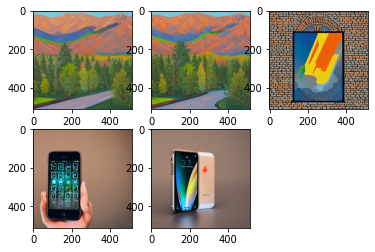

In [6]:

def export_as_gif(filename, images, frames_per_second=10, rubber_band=False):
    if rubber_band:
        images += images[2:-1][::-1]
    images[0].save(
        filename,
        save_all=True,
        append_images=images[1:],
        duration=1000 // frames_per_second,
        loop=0,
    )
print('total images generated :',len(images))

for i in range(len(images)):
  plt.subplot(2,3,i+1)
  plt.imshow(images[i],cmap='gray')
plt.show()

export_as_gif(
    "CSU+iphone.gif",
    [Image.fromarray(img) for img in images],
    frames_per_second=1,
    rubber_band=True,
)

In [ ]:
interpolation_steps = 150
batch_size = 3
batches = interpolation_steps // batch_size

interpolated_encodings = tf.linspace(encoding_1, encoding_2, interpolation_steps)
batched_encodings = tf.split(interpolated_encodings, batches)

images = []
for batch in range(batches):
    images += [
        Image.fromarray(img)
        for img in model.generate_image(
            batched_encodings[batch],
            batch_size=batch_size,
            num_steps=25,
            diffusion_noise=noise,
        )
    ]

export_as_gif("doggo-and-fruit-150.gif", images, rubber_band=True)



We can even extend this concept for more than one image. For example, we can
interpolate between four prompts:

In [22]:
prompt_1 = "Student Coding on Macbook"
prompt_2 = "Neural Network being taught by professor"
prompt_3 = "painting of colorado state university"
prompt_4 = "Futuristic picture of Kashmir"

interpolation_steps = 6
batch_size = 3
batches = (interpolation_steps**2) // batch_size

encoding_1 = tf.squeeze(model.encode_text(prompt_1))
encoding_2 = tf.squeeze(model.encode_text(prompt_2))
encoding_3 = tf.squeeze(model.encode_text(prompt_3))
encoding_4 = tf.squeeze(model.encode_text(prompt_4))

interpolated_encodings = tf.linspace(
    tf.linspace(encoding_1, encoding_2, interpolation_steps),
    tf.linspace(encoding_3, encoding_4, interpolation_steps),
    interpolation_steps,
)
interpolated_encodings = tf.reshape(
    interpolated_encodings, (interpolation_steps**2, 77, 768)
)
batched_encodings = tf.split(interpolated_encodings, batches)

images = []
for batch in range(batches):
    images.append(
        model.generate_image(
            batched_encodings[batch],
            batch_size=batch_size,
            diffusion_noise=noise,
        )
    )


def plot_grid(
    images,
    path,
    grid_size,
    scale=2,
):
    fig = plt.figure(figsize=(grid_size * scale, grid_size * scale))
    fig.tight_layout()
    plt.subplots_adjust(wspace=0, hspace=0)
    plt.margins(x=0, y=0)
    plt.axis("off")
    images = images.astype(int)
    for row in range(grid_size):
        for col in range(grid_size):
            index = row * grid_size + col
            plt.subplot(grid_size, grid_size, index + 1)
            plt.imshow(images[index].astype("uint8"))
            plt.axis("off")
            plt.margins(x=0, y=0)
    plt.savefig(
        fname=path,
        pad_inches=0,
        bbox_inches="tight",
        transparent=False,
        dpi=60,
    )


images = np.concatenate(images)
plot_grid(images, "4-way-interpolation.jpg", interpolation_steps)

2023-05-02 20:08:10.196250: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int32 and shape [1,77]
	 [[{{node Placeholder/_1}}]]
2023-05-02 20:08:10.265007: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int32 and shape [1,77]
	 [[{{node Placeholder/_1}}]]
2023-05-02 20:08:10.333640: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int32 and shape [1,77]
	

 1/50 [..............................] - ETA: 31:44

2023-05-02 20:08:49.410193: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype half and shape [3,77,768]
	 [[{{node Placeholder/_2}}]]
2023-05-02 20:08:58.673385: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype half and shape [3,77,768]
	 [[{{node Placeholder/_2}}]]


 2/50 [>.............................] - ETA: 14:50

2023-05-02 20:09:07.972225: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype half and shape [3,77,768]
	 [[{{node Placeholder/_2}}]]
2023-05-02 20:09:17.239237: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype half and shape [3,77,768]
	 [[{{node Placeholder/_2}}]]


 3/50 [>.............................] - ETA: 14:34

2023-05-02 20:09:26.611961: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype half and shape [3,77,768]
	 [[{{node Placeholder/_2}}]]
2023-05-02 20:09:35.950984: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype half and shape [3,77,768]
	 [[{{node Placeholder/_2}}]]


 4/50 [=>............................] - ETA: 14:17

2023-05-02 20:09:45.306644: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype half and shape [3,77,768]
	 [[{{node Placeholder/_2}}]]
2023-05-02 20:09:54.706056: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype half and shape [3,77,768]
	 [[{{node Placeholder/_2}}]]


 5/50 [==>...........................] - ETA: 14:00

2023-05-02 20:10:04.086653: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype half and shape [3,77,768]
	 [[{{node Placeholder/_2}}]]
2023-05-02 20:10:13.457786: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype half and shape [3,77,768]
	 [[{{node Placeholder/_2}}]]


 6/50 [==>...........................] - ETA: 13:43

2023-05-02 20:10:22.963914: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype half and shape [3,77,768]
	 [[{{node Placeholder/_2}}]]
2023-05-02 20:10:32.435283: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype half and shape [3,77,768]
	 [[{{node Placeholder/_2}}]]


 7/50 [===>..........................] - ETA: 13:26

2023-05-02 20:10:41.907750: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype half and shape [3,77,768]
	 [[{{node Placeholder/_2}}]]
2023-05-02 20:10:51.371228: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype half and shape [3,77,768]
	 [[{{node Placeholder/_2}}]]


 8/50 [===>..........................] - ETA: 13:08

2023-05-02 20:11:00.756711: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype half and shape [3,77,768]
	 [[{{node Placeholder/_2}}]]
2023-05-02 20:11:10.217564: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype half and shape [3,77,768]
	 [[{{node Placeholder/_2}}]]


 9/50 [====>.........................] - ETA: 12:49

2023-05-02 20:11:19.620647: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype half and shape [3,77,768]
	 [[{{node Placeholder/_2}}]]
2023-05-02 20:11:29.095920: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype half and shape [3,77,768]
	 [[{{node Placeholder/_2}}]]


10/50 [=====>........................] - ETA: 12:32

2023-05-02 20:11:38.612137: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype half and shape [3,77,768]
	 [[{{node Placeholder/_2}}]]
2023-05-02 20:11:48.063951: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype half and shape [3,77,768]
	 [[{{node Placeholder/_2}}]]


11/50 [=====>........................] - ETA: 12:13

2023-05-02 20:11:57.445710: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype half and shape [3,77,768]
	 [[{{node Placeholder/_2}}]]
2023-05-02 20:12:06.913566: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype half and shape [3,77,768]
	 [[{{node Placeholder/_2}}]]


12/50 [======>.......................] - ETA: 11:54

2023-05-02 20:12:16.367988: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype half and shape [3,77,768]
	 [[{{node Placeholder/_2}}]]
2023-05-02 20:12:25.834313: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype half and shape [3,77,768]
	 [[{{node Placeholder/_2}}]]


13/50 [======>.......................] - ETA: 11:36

2023-05-02 20:12:35.302251: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype half and shape [3,77,768]
	 [[{{node Placeholder/_2}}]]
2023-05-02 20:12:44.746816: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype half and shape [3,77,768]
	 [[{{node Placeholder/_2}}]]


14/50 [=======>......................] - ETA: 11:17

2023-05-02 20:12:54.171664: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype half and shape [3,77,768]
	 [[{{node Placeholder/_2}}]]
2023-05-02 20:13:03.711728: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype half and shape [3,77,768]
	 [[{{node Placeholder/_2}}]]


15/50 [========>.....................] - ETA: 10:59

2023-05-02 20:13:13.191341: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype half and shape [3,77,768]
	 [[{{node Placeholder/_2}}]]
2023-05-02 20:13:22.681281: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype half and shape [3,77,768]
	 [[{{node Placeholder/_2}}]]


16/50 [========>.....................] - ETA: 10:41

2023-05-02 20:13:32.220905: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype half and shape [3,77,768]
	 [[{{node Placeholder/_2}}]]
2023-05-02 20:13:41.719676: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype half and shape [3,77,768]
	 [[{{node Placeholder/_2}}]]


17/50 [=========>....................] - ETA: 10:22

2023-05-02 20:13:51.239765: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype half and shape [3,77,768]
	 [[{{node Placeholder/_2}}]]
2023-05-02 20:14:00.741711: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype half and shape [3,77,768]
	 [[{{node Placeholder/_2}}]]


18/50 [=========>....................] - ETA: 10:03

2023-05-02 20:14:10.225198: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype half and shape [3,77,768]
	 [[{{node Placeholder/_2}}]]
2023-05-02 20:14:19.747892: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype half and shape [3,77,768]
	 [[{{node Placeholder/_2}}]]


19/50 [==========>...................] - ETA: 9:45 

2023-05-02 20:14:29.250583: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype half and shape [3,77,768]
	 [[{{node Placeholder/_2}}]]
2023-05-02 20:14:38.734430: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype half and shape [3,77,768]
	 [[{{node Placeholder/_2}}]]


20/50 [===========>..................] - ETA: 9:26

2023-05-02 20:14:48.211014: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype half and shape [3,77,768]
	 [[{{node Placeholder/_2}}]]
2023-05-02 20:14:57.678634: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype half and shape [3,77,768]
	 [[{{node Placeholder/_2}}]]


21/50 [===========>..................] - ETA: 9:07

2023-05-02 20:15:07.187905: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype half and shape [3,77,768]
	 [[{{node Placeholder/_2}}]]
2023-05-02 20:15:16.604156: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype half and shape [3,77,768]
	 [[{{node Placeholder/_2}}]]


22/50 [============>.................] - ETA: 8:48

2023-05-02 20:15:26.099368: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype half and shape [3,77,768]
	 [[{{node Placeholder/_2}}]]
2023-05-02 20:15:35.747652: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype half and shape [3,77,768]
	 [[{{node Placeholder/_2}}]]


23/50 [============>.................] - ETA: 8:30

2023-05-02 20:15:45.386867: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype half and shape [3,77,768]
	 [[{{node Placeholder/_2}}]]
2023-05-02 20:15:54.898737: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype half and shape [3,77,768]
	 [[{{node Placeholder/_2}}]]


24/50 [=============>................] - ETA: 8:11

2023-05-02 20:16:04.356236: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype half and shape [3,77,768]
	 [[{{node Placeholder/_2}}]]
2023-05-02 20:16:13.871465: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype half and shape [3,77,768]
	 [[{{node Placeholder/_2}}]]


25/50 [==============>...............] - ETA: 7:52

2023-05-02 20:16:23.366958: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype half and shape [3,77,768]
	 [[{{node Placeholder/_2}}]]
2023-05-02 20:16:32.860765: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype half and shape [3,77,768]
	 [[{{node Placeholder/_2}}]]


26/50 [==============>...............] - ETA: 7:34

2023-05-02 20:16:42.395796: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype half and shape [3,77,768]
	 [[{{node Placeholder/_2}}]]
2023-05-02 20:16:51.892550: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype half and shape [3,77,768]
	 [[{{node Placeholder/_2}}]]


27/50 [===============>..............] - ETA: 7:15

2023-05-02 20:17:01.375700: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype half and shape [3,77,768]
	 [[{{node Placeholder/_2}}]]
2023-05-02 20:17:10.896478: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype half and shape [3,77,768]
	 [[{{node Placeholder/_2}}]]


28/50 [===============>..............] - ETA: 6:56

2023-05-02 20:17:20.433593: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype half and shape [3,77,768]
	 [[{{node Placeholder/_2}}]]
2023-05-02 20:17:29.977183: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype half and shape [3,77,768]
	 [[{{node Placeholder/_2}}]]


29/50 [================>.............] - ETA: 6:37

2023-05-02 20:17:39.515896: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype half and shape [3,77,768]
	 [[{{node Placeholder/_2}}]]
2023-05-02 20:17:49.033650: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype half and shape [3,77,768]
	 [[{{node Placeholder/_2}}]]


30/50 [=================>............] - ETA: 6:18

2023-05-02 20:17:58.513637: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype half and shape [3,77,768]
	 [[{{node Placeholder/_2}}]]
2023-05-02 20:18:08.025788: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype half and shape [3,77,768]
	 [[{{node Placeholder/_2}}]]


31/50 [=================>............] - ETA: 5:59

2023-05-02 20:18:17.506907: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype half and shape [3,77,768]
	 [[{{node Placeholder/_2}}]]
2023-05-02 20:18:27.054157: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype half and shape [3,77,768]
	 [[{{node Placeholder/_2}}]]


32/50 [==================>...........] - ETA: 5:40

2023-05-02 20:18:36.558265: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype half and shape [3,77,768]
	 [[{{node Placeholder/_2}}]]
2023-05-02 20:18:46.106509: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype half and shape [3,77,768]
	 [[{{node Placeholder/_2}}]]


33/50 [==================>...........] - ETA: 5:22

2023-05-02 20:18:55.608773: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype half and shape [3,77,768]
	 [[{{node Placeholder/_2}}]]
2023-05-02 20:19:05.177540: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype half and shape [3,77,768]
	 [[{{node Placeholder/_2}}]]


34/50 [===================>..........] - ETA: 5:03

2023-05-02 20:19:14.686900: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype half and shape [3,77,768]
	 [[{{node Placeholder/_2}}]]
2023-05-02 20:19:24.184873: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype half and shape [3,77,768]
	 [[{{node Placeholder/_2}}]]


35/50 [====================>.........] - ETA: 4:44

2023-05-02 20:19:33.689496: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype half and shape [3,77,768]
	 [[{{node Placeholder/_2}}]]
2023-05-02 20:19:43.212267: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype half and shape [3,77,768]
	 [[{{node Placeholder/_2}}]]


36/50 [====================>.........] - ETA: 4:25

2023-05-02 20:19:52.730128: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype half and shape [3,77,768]
	 [[{{node Placeholder/_2}}]]
2023-05-02 20:20:02.289764: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype half and shape [3,77,768]
	 [[{{node Placeholder/_2}}]]


37/50 [=====================>........] - ETA: 4:06

2023-05-02 20:20:11.789173: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype half and shape [3,77,768]
	 [[{{node Placeholder/_2}}]]
2023-05-02 20:20:21.294253: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype half and shape [3,77,768]
	 [[{{node Placeholder/_2}}]]


38/50 [=====================>........] - ETA: 3:47

2023-05-02 20:20:30.855893: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype half and shape [3,77,768]
	 [[{{node Placeholder/_2}}]]
2023-05-02 20:20:40.366365: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype half and shape [3,77,768]
	 [[{{node Placeholder/_2}}]]


39/50 [======================>.......] - ETA: 3:28

2023-05-02 20:20:49.903438: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype half and shape [3,77,768]
	 [[{{node Placeholder/_2}}]]
2023-05-02 20:20:59.359451: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype half and shape [3,77,768]
	 [[{{node Placeholder/_2}}]]


40/50 [=======================>......] - ETA: 3:09

2023-05-02 20:21:08.833283: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype half and shape [3,77,768]
	 [[{{node Placeholder/_2}}]]
2023-05-02 20:21:18.329464: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype half and shape [3,77,768]
	 [[{{node Placeholder/_2}}]]


41/50 [=======================>......] - ETA: 2:50

2023-05-02 20:21:27.833880: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype half and shape [3,77,768]
	 [[{{node Placeholder/_2}}]]
2023-05-02 20:21:37.317246: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype half and shape [3,77,768]
	 [[{{node Placeholder/_2}}]]


42/50 [========================>.....] - ETA: 2:31

2023-05-02 20:21:46.781864: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype half and shape [3,77,768]
	 [[{{node Placeholder/_2}}]]
2023-05-02 20:21:56.307774: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype half and shape [3,77,768]
	 [[{{node Placeholder/_2}}]]


43/50 [========================>.....] - ETA: 2:12

2023-05-02 20:22:05.783680: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype half and shape [3,77,768]
	 [[{{node Placeholder/_2}}]]
2023-05-02 20:22:15.272332: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype half and shape [3,77,768]
	 [[{{node Placeholder/_2}}]]


44/50 [=========================>....] - ETA: 1:53

2023-05-02 20:22:24.743358: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype half and shape [3,77,768]
	 [[{{node Placeholder/_2}}]]
2023-05-02 20:22:34.249516: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype half and shape [3,77,768]
	 [[{{node Placeholder/_2}}]]


45/50 [==========================>...] - ETA: 1:34

2023-05-02 20:22:43.759065: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype half and shape [3,77,768]
	 [[{{node Placeholder/_2}}]]
2023-05-02 20:22:53.236315: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype half and shape [3,77,768]
	 [[{{node Placeholder/_2}}]]


46/50 [==========================>...] - ETA: 1:15

2023-05-02 20:23:02.734342: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype half and shape [3,77,768]
	 [[{{node Placeholder/_2}}]]
2023-05-02 20:23:12.233212: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype half and shape [3,77,768]
	 [[{{node Placeholder/_2}}]]


47/50 [===========================>..] - ETA: 56s 

2023-05-02 20:23:21.709781: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype half and shape [3,77,768]
	 [[{{node Placeholder/_2}}]]
2023-05-02 20:23:31.251215: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype half and shape [3,77,768]
	 [[{{node Placeholder/_2}}]]


48/50 [===========================>..] - ETA: 37s

2023-05-02 20:23:40.771391: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype half and shape [3,77,768]
	 [[{{node Placeholder/_2}}]]
2023-05-02 20:23:50.278258: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype half and shape [3,77,768]
	 [[{{node Placeholder/_2}}]]


49/50 [============================>.] - ETA: 18s

2023-05-02 20:23:59.771495: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype half and shape [3,77,768]
	 [[{{node Placeholder/_2}}]]
2023-05-02 20:24:09.274459: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype half and shape [3,77,768]
	 [[{{node Placeholder/_2}}]]


50/50 [==============================] - 968s 19s/step


2023-05-02 20:24:18.766775: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype float and shape [3,64,64,4]
	 [[{{node Placeholder/_0}}]]
2023-05-02 20:24:34.174000: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int32 and shape [1,77]
	 [[{{node Placeholder/_1}}]]
2023-05-02 20:24:34.248887: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype half and shape [3,7

 1/50 [..............................] - ETA: 15:05

2023-05-02 20:24:52.721320: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype half and shape [3,77,768]
	 [[{{node Placeholder/_2}}]]
2023-05-02 20:25:01.973152: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype half and shape [3,77,768]
	 [[{{node Placeholder/_2}}]]


 2/50 [>.............................] - ETA: 14:48

2023-05-02 20:25:11.230401: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype half and shape [3,77,768]
	 [[{{node Placeholder/_2}}]]
2023-05-02 20:25:20.490260: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype half and shape [3,77,768]
	 [[{{node Placeholder/_2}}]]


 3/50 [>.............................] - ETA: 14:30

2023-05-02 20:25:29.778463: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype half and shape [3,77,768]
	 [[{{node Placeholder/_2}}]]
2023-05-02 20:25:39.097250: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype half and shape [3,77,768]
	 [[{{node Placeholder/_2}}]]


 4/50 [=>............................] - ETA: 14:14

2023-05-02 20:25:48.427137: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype half and shape [3,77,768]
	 [[{{node Placeholder/_2}}]]
2023-05-02 20:25:57.763231: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype half and shape [3,77,768]
	 [[{{node Placeholder/_2}}]]


 5/50 [==>...........................] - ETA: 13:55

2023-05-02 20:26:07.014634: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype half and shape [3,77,768]
	 [[{{node Placeholder/_2}}]]
2023-05-02 20:26:16.318662: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype half and shape [3,77,768]
	 [[{{node Placeholder/_2}}]]


 6/50 [==>...........................] - ETA: 13:38

2023-05-02 20:26:25.693007: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype half and shape [3,77,768]
	 [[{{node Placeholder/_2}}]]
2023-05-02 20:26:35.037365: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype half and shape [3,77,768]
	 [[{{node Placeholder/_2}}]]


 7/50 [===>..........................] - ETA: 13:20

2023-05-02 20:26:44.405004: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype half and shape [3,77,768]
	 [[{{node Placeholder/_2}}]]
2023-05-02 20:26:53.774736: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype half and shape [3,77,768]
	 [[{{node Placeholder/_2}}]]


 8/50 [===>..........................] - ETA: 13:02

2023-05-02 20:27:03.084332: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype half and shape [3,77,768]
	 [[{{node Placeholder/_2}}]]
2023-05-02 20:27:12.650500: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype half and shape [3,77,768]
	 [[{{node Placeholder/_2}}]]


 9/50 [====>.........................] - ETA: 12:45

2023-05-02 20:27:22.078068: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype half and shape [3,77,768]
	 [[{{node Placeholder/_2}}]]
2023-05-02 20:27:31.462412: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype half and shape [3,77,768]
	 [[{{node Placeholder/_2}}]]


10/50 [=====>........................] - ETA: 12:27

2023-05-02 20:27:40.843125: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype half and shape [3,77,768]
	 [[{{node Placeholder/_2}}]]
2023-05-02 20:27:50.169018: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype half and shape [3,77,768]
	 [[{{node Placeholder/_2}}]]


11/50 [=====>........................] - ETA: 12:08

2023-05-02 20:27:59.504911: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype half and shape [3,77,768]
	 [[{{node Placeholder/_2}}]]
2023-05-02 20:28:08.936205: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype half and shape [3,77,768]
	 [[{{node Placeholder/_2}}]]


12/50 [======>.......................] - ETA: 11:50

2023-05-02 20:28:18.261286: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype half and shape [3,77,768]
	 [[{{node Placeholder/_2}}]]
2023-05-02 20:28:27.625485: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype half and shape [3,77,768]
	 [[{{node Placeholder/_2}}]]


13/50 [======>.......................] - ETA: 11:31

2023-05-02 20:28:37.028382: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype half and shape [3,77,768]
	 [[{{node Placeholder/_2}}]]
2023-05-02 20:28:46.364877: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype half and shape [3,77,768]
	 [[{{node Placeholder/_2}}]]


14/50 [=======>......................] - ETA: 11:13

2023-05-02 20:28:55.752810: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype half and shape [3,77,768]
	 [[{{node Placeholder/_2}}]]
2023-05-02 20:29:05.112299: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype half and shape [3,77,768]
	 [[{{node Placeholder/_2}}]]


15/50 [========>.....................] - ETA: 10:54

2023-05-02 20:29:14.474436: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype half and shape [3,77,768]
	 [[{{node Placeholder/_2}}]]
2023-05-02 20:29:23.827282: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype half and shape [3,77,768]
	 [[{{node Placeholder/_2}}]]


16/50 [========>.....................] - ETA: 10:35

2023-05-02 20:29:33.150016: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype half and shape [3,77,768]
	 [[{{node Placeholder/_2}}]]
2023-05-02 20:29:42.479984: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype half and shape [3,77,768]
	 [[{{node Placeholder/_2}}]]


17/50 [=========>....................] - ETA: 10:16

2023-05-02 20:29:51.817025: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype half and shape [3,77,768]
	 [[{{node Placeholder/_2}}]]
2023-05-02 20:30:01.170637: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype half and shape [3,77,768]
	 [[{{node Placeholder/_2}}]]


18/50 [=========>....................] - ETA: 9:58 

2023-05-02 20:30:10.508346: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype half and shape [3,77,768]
	 [[{{node Placeholder/_2}}]]
2023-05-02 20:30:19.843044: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype half and shape [3,77,768]
	 [[{{node Placeholder/_2}}]]


19/50 [==========>...................] - ETA: 9:39

2023-05-02 20:30:29.208703: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype half and shape [3,77,768]
	 [[{{node Placeholder/_2}}]]
2023-05-02 20:30:38.558740: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype half and shape [3,77,768]
	 [[{{node Placeholder/_2}}]]


20/50 [===========>..................] - ETA: 9:20

2023-05-02 20:30:47.886643: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype half and shape [3,77,768]
	 [[{{node Placeholder/_2}}]]
2023-05-02 20:30:57.270316: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype half and shape [3,77,768]
	 [[{{node Placeholder/_2}}]]


21/50 [===========>..................] - ETA: 9:02

2023-05-02 20:31:06.621043: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype half and shape [3,77,768]
	 [[{{node Placeholder/_2}}]]
2023-05-02 20:31:15.965329: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype half and shape [3,77,768]
	 [[{{node Placeholder/_2}}]]


22/50 [============>.................] - ETA: 8:43

2023-05-02 20:31:25.324019: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype half and shape [3,77,768]
	 [[{{node Placeholder/_2}}]]
2023-05-02 20:31:34.669996: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype half and shape [3,77,768]
	 [[{{node Placeholder/_2}}]]


23/50 [============>.................] - ETA: 8:24

2023-05-02 20:31:43.953480: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype half and shape [3,77,768]
	 [[{{node Placeholder/_2}}]]
2023-05-02 20:31:53.242964: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype half and shape [3,77,768]
	 [[{{node Placeholder/_2}}]]


24/50 [=============>................] - ETA: 8:05

2023-05-02 20:32:02.577499: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype half and shape [3,77,768]
	 [[{{node Placeholder/_2}}]]
2023-05-02 20:32:11.916246: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype half and shape [3,77,768]
	 [[{{node Placeholder/_2}}]]


25/50 [==============>...............] - ETA: 7:47

2023-05-02 20:32:21.266922: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype half and shape [3,77,768]
	 [[{{node Placeholder/_2}}]]
2023-05-02 20:32:30.581686: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype half and shape [3,77,768]
	 [[{{node Placeholder/_2}}]]


26/50 [==============>...............] - ETA: 7:28

2023-05-02 20:32:39.894082: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype half and shape [3,77,768]
	 [[{{node Placeholder/_2}}]]
2023-05-02 20:32:49.220089: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype half and shape [3,77,768]
	 [[{{node Placeholder/_2}}]]


27/50 [===============>..............] - ETA: 7:09

2023-05-02 20:32:58.535084: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype half and shape [3,77,768]
	 [[{{node Placeholder/_2}}]]
2023-05-02 20:33:07.877364: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype half and shape [3,77,768]
	 [[{{node Placeholder/_2}}]]


28/50 [===============>..............] - ETA: 6:51

2023-05-02 20:33:17.218388: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype half and shape [3,77,768]
	 [[{{node Placeholder/_2}}]]
2023-05-02 20:33:26.512422: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype half and shape [3,77,768]
	 [[{{node Placeholder/_2}}]]


29/50 [================>.............] - ETA: 6:32

2023-05-02 20:33:35.821539: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype half and shape [3,77,768]
	 [[{{node Placeholder/_2}}]]
2023-05-02 20:33:45.108722: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype half and shape [3,77,768]
	 [[{{node Placeholder/_2}}]]


30/50 [=================>............] - ETA: 6:13

2023-05-02 20:33:54.453084: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype half and shape [3,77,768]
	 [[{{node Placeholder/_2}}]]
2023-05-02 20:34:03.768492: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype half and shape [3,77,768]
	 [[{{node Placeholder/_2}}]]


31/50 [=================>............] - ETA: 5:54

2023-05-02 20:34:13.074744: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype half and shape [3,77,768]
	 [[{{node Placeholder/_2}}]]
2023-05-02 20:34:22.464362: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype half and shape [3,77,768]
	 [[{{node Placeholder/_2}}]]


32/50 [==================>...........] - ETA: 5:36

2023-05-02 20:34:31.850317: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype half and shape [3,77,768]
	 [[{{node Placeholder/_2}}]]
2023-05-02 20:34:41.198183: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype half and shape [3,77,768]
	 [[{{node Placeholder/_2}}]]


33/50 [==================>...........] - ETA: 5:17

2023-05-02 20:34:50.564585: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype half and shape [3,77,768]
	 [[{{node Placeholder/_2}}]]
2023-05-02 20:34:59.879887: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype half and shape [3,77,768]
	 [[{{node Placeholder/_2}}]]


34/50 [===================>..........] - ETA: 4:58

2023-05-02 20:35:09.180080: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype half and shape [3,77,768]
	 [[{{node Placeholder/_2}}]]
2023-05-02 20:35:18.485330: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype half and shape [3,77,768]
	 [[{{node Placeholder/_2}}]]


35/50 [====================>.........] - ETA: 4:40

2023-05-02 20:35:27.821487: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype half and shape [3,77,768]
	 [[{{node Placeholder/_2}}]]
2023-05-02 20:35:37.159380: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype half and shape [3,77,768]
	 [[{{node Placeholder/_2}}]]


36/50 [====================>.........] - ETA: 4:21

2023-05-02 20:35:46.506085: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype half and shape [3,77,768]
	 [[{{node Placeholder/_2}}]]
2023-05-02 20:35:55.842105: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype half and shape [3,77,768]
	 [[{{node Placeholder/_2}}]]


37/50 [=====================>........] - ETA: 4:02

2023-05-02 20:36:05.192252: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype half and shape [3,77,768]
	 [[{{node Placeholder/_2}}]]
2023-05-02 20:36:14.516002: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype half and shape [3,77,768]
	 [[{{node Placeholder/_2}}]]


38/50 [=====================>........] - ETA: 3:44

2023-05-02 20:36:23.804581: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype half and shape [3,77,768]
	 [[{{node Placeholder/_2}}]]
2023-05-02 20:36:33.109826: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype half and shape [3,77,768]
	 [[{{node Placeholder/_2}}]]


39/50 [======================>.......] - ETA: 3:25

2023-05-02 20:36:42.472798: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype half and shape [3,77,768]
	 [[{{node Placeholder/_2}}]]
2023-05-02 20:36:51.781619: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype half and shape [3,77,768]
	 [[{{node Placeholder/_2}}]]


40/50 [=======================>......] - ETA: 3:06

2023-05-02 20:37:01.155036: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype half and shape [3,77,768]
	 [[{{node Placeholder/_2}}]]
2023-05-02 20:37:10.432909: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype half and shape [3,77,768]
	 [[{{node Placeholder/_2}}]]


41/50 [=======================>......] - ETA: 2:48

2023-05-02 20:37:19.781659: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype half and shape [3,77,768]
	 [[{{node Placeholder/_2}}]]
2023-05-02 20:37:29.118582: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype half and shape [3,77,768]
	 [[{{node Placeholder/_2}}]]


42/50 [========================>.....] - ETA: 2:29

2023-05-02 20:37:38.379468: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype half and shape [3,77,768]
	 [[{{node Placeholder/_2}}]]
2023-05-02 20:37:47.704122: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype half and shape [3,77,768]
	 [[{{node Placeholder/_2}}]]


43/50 [========================>.....] - ETA: 2:10

2023-05-02 20:37:56.988683: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype half and shape [3,77,768]
	 [[{{node Placeholder/_2}}]]
2023-05-02 20:38:06.325312: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype half and shape [3,77,768]
	 [[{{node Placeholder/_2}}]]


44/50 [=========================>....] - ETA: 1:52

2023-05-02 20:38:15.674633: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype half and shape [3,77,768]
	 [[{{node Placeholder/_2}}]]
2023-05-02 20:38:24.996295: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype half and shape [3,77,768]
	 [[{{node Placeholder/_2}}]]


45/50 [==========================>...] - ETA: 1:33

2023-05-02 20:38:34.324413: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype half and shape [3,77,768]
	 [[{{node Placeholder/_2}}]]
2023-05-02 20:38:43.656482: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype half and shape [3,77,768]
	 [[{{node Placeholder/_2}}]]


46/50 [==========================>...] - ETA: 1:14

2023-05-02 20:38:53.024146: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype half and shape [3,77,768]
	 [[{{node Placeholder/_2}}]]
2023-05-02 20:39:02.374779: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype half and shape [3,77,768]
	 [[{{node Placeholder/_2}}]]


47/50 [===========================>..] - ETA: 56s 

2023-05-02 20:39:11.688074: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype half and shape [3,77,768]
	 [[{{node Placeholder/_2}}]]
2023-05-02 20:39:21.034092: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype half and shape [3,77,768]
	 [[{{node Placeholder/_2}}]]


48/50 [===========================>..] - ETA: 37s

2023-05-02 20:39:30.363292: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype half and shape [3,77,768]
	 [[{{node Placeholder/_2}}]]
2023-05-02 20:39:39.717748: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype half and shape [3,77,768]
	 [[{{node Placeholder/_2}}]]


49/50 [============================>.] - ETA: 18s

2023-05-02 20:39:49.064141: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype half and shape [3,77,768]
	 [[{{node Placeholder/_2}}]]
2023-05-02 20:39:58.362489: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype half and shape [3,77,768]
	 [[{{node Placeholder/_2}}]]


50/50 [==============================] - 933s 19s/step


2023-05-02 20:40:07.714375: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype float and shape [3,64,64,4]
	 [[{{node Placeholder/_0}}]]
2023-05-02 20:40:20.117682: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int32 and shape [1,77]
	 [[{{node Placeholder/_1}}]]
2023-05-02 20:40:20.194281: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype half and shape [3,7

 1/50 [..............................] - ETA: 15:06

2023-05-02 20:40:38.688884: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype half and shape [3,77,768]
	 [[{{node Placeholder/_2}}]]
2023-05-02 20:40:47.964177: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype half and shape [3,77,768]
	 [[{{node Placeholder/_2}}]]


 2/50 [>.............................] - ETA: 14:49

2023-05-02 20:40:57.223586: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype half and shape [3,77,768]
	 [[{{node Placeholder/_2}}]]
2023-05-02 20:41:06.517460: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype half and shape [3,77,768]
	 [[{{node Placeholder/_2}}]]


 3/50 [>.............................] - ETA: 14:34

2023-05-02 20:41:15.881989: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype half and shape [3,77,768]
	 [[{{node Placeholder/_2}}]]
2023-05-02 20:41:25.189679: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype half and shape [3,77,768]
	 [[{{node Placeholder/_2}}]]


 4/50 [=>............................] - ETA: 14:17

2023-05-02 20:41:34.581850: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype half and shape [3,77,768]
	 [[{{node Placeholder/_2}}]]
